##Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pwd
# Change directory
%cd ../content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
!pwd

/content
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0


# Setup

Libraries

In [ ]:
import pandas as pd
import numpy as np
import zipfile
# NLTK
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import re # to clean text
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
from matplotlib.gridspec import GridSpec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Test function import

In [30]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0/utils')
execfile('utils/test.py')
hello()

Hello world


In [ ]:
# Create data folder
#%mkdir data

#Data preparation
reference to tutorial:
https://ourcodingclub.github.io/tutorials/topic-modelling-python/#clean

## Extract data

In [ ]:
# Extract from xip file
# with zipfile.ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

In [ ]:
# read in training data
data = pd.read_csv("data/train.csv")
data.reset_index(inplace=True)

In [ ]:
# data info
print("Shape:",data.shape)
print("Columns:\n",data.columns)
print(data.head(5))
print("Missing volumes:\n",data.isna().sum())

Shape: (7613, 6)
Columns:
 Index(['index', 'id', 'keyword', 'location', 'text', 'target'], dtype='object')
   index  id keyword location  \
0      0   1     NaN      NaN   
1      1   4     NaN      NaN   
2      2   5     NaN      NaN   
3      3   6     NaN      NaN   
4      4   7     NaN      NaN   

                                                text  target  
0  Our Deeds are the Reason of this #earthquake M...       1  
1             Forest fire near La Ronge Sask. Canada       1  
2  All residents asked to 'shelter in place' are ...       1  
3  13,000 people receive #wildfires evacuation or...       1  
4  Just got sent this photo from Ruby #Alaska as ...       1  
Missing volumes:
 index          0
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


## Tokenize, tidy & reshape

### Tidy Words

In [ ]:
# Combine all words
words_all = []
words_idx = []
words_tgt = []
for s in range(len(data)):
  words_all += word_tokenize(data.text[s])
  words_idx += [s]*len(word_tokenize(data.text[s]))
  words_tgt += [data.target[s]]*len(word_tokenize(data.text[s]))
print(words_all[:3])
print(words_idx[:3])
print(words_tgt[:3])

# Combine into dataframe
words = pd.DataFrame()
words['idx'] = words_idx
words['tgt'] = words_tgt
words['word'] = words_all
words.head(3)

['Our', 'Deeds', 'are']
[0, 0, 0]
[1, 1, 1]


,idx,tgt,word
0,0,1,Our
1,0,1,Deeds
2,0,1,are


In [ ]:
# Remove punctuation 
words_pnk = []
for w in range(len(words)):
  if words.word[w].isalpha():
    words_pnk.append(words.loc[w])
words_pnk = pd.DataFrame(words_pnk, columns = words.columns)
words_pnk.reset_index(inplace=True, drop=True)
words_pnk.head(3)

,idx,tgt,word
0,0,1,Our
1,0,1,Deeds
2,0,1,are


In [ ]:
# Remove stopwords
stpwords = stopwords.words("english")
# Edit stopwords list
stpwords = stpwords + ['I','A','the','http','The','https','a']
words_stp = []
for w in range(len(words_pnk)):
  if words_pnk.word[w] not in stpwords:
    words_stp.append(words_pnk.loc[w])
words_stp = pd.DataFrame(words_stp, columns = words.columns)
words_stp.reset_index(inplace=True, drop=True)
words_stp.head(3)

,idx,tgt,word
0,0,1,Our
1,0,1,Deeds
2,0,1,Reason


In [ ]:
# Stemming
porter = PorterStemmer()
for w in range(len(words_stp)):
  words_stp.loc[w,'word_ste'] = porter.stem(words_stp.word.loc[w])
words_stp.head(3)

,idx,tgt,word,word_ste
0,0,1,Our,our
1,0,1,Deeds,deed
2,0,1,Reason,reason


In [ ]:
print(words_stp.word.nunique())
print(words_stp.word_ste.nunique())

18888
12281


   idx  tgt        word   word_ste  tag
0    0    1         Our        our  PRP
1    0    1       Deeds       deed  NNS
2    0    1      Reason     reason   NN
3    0    1  earthquake  earthquak   NN
4    0    1         May        may  NNP


<BarContainer object of 10 artists>

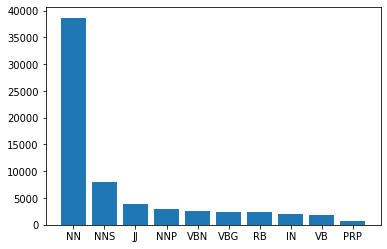

In [ ]:
# Add tag
for w in range(len(words_stp)):
  words_stp.loc[w,'tag'] = nltk.pos_tag([words_stp.word[w]])[0][1].replace('$', '')
print(words_stp.head(5))
#print(words_stp.groupby('tag').tag.count())
plt.bar(words_stp.tag.value_counts().sort_values(ascending=False)[:10].reset_index()['index'],words_stp.tag.value_counts().sort_values(ascending=False)[:10].reset_index()['tag'])

### Tidy sentences

In [ ]:
# # Sentences tokenizing
# sent_all = []
# sent_idx = []
# for s in range(len(data)):
#   sent_all += sent_tokenize(data.text[s])
#   sent_idx += [s]*len(sent_tokenize(data.text[s]))
# print(sent_all[:3])
# print(sent_idx[:3])

# # Combine into dataframe
# sent = pd.DataFrame()
# sent['idx'] = sent_idx
# sent['sent'] = sent_all
# sent.head(3)

sent = data[['text']].copy()

In [ ]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [ ]:
my_stopwords = stopwords.words("english")
my_stopwords = my_stopwords + ['I','A','the','The','a']
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [ ]:
sent['clean_tweet'] = sent.text.apply(clean_tweet)
sent.head(5)

,text,clean_tweet
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


In [ ]:
sent[sent.clean_tweet.isna()]

,text,clean_tweet


### Phrases

In [ ]:
# Phrases tokenizing - Chunking
grammar = "NP: {<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(grammar)
chunks = []
for i in range(words_stp.idx.max()):
  s = words_stp[words_stp.idx==i].word
  tree = chunk_parser.parse(nltk.pos_tag(s))
  chunks.append(tree)


In [ ]:
# Phrases tokenizing - Chinking
grammar = """
 Chunk: {<.*>+}
        }<JJ>{"""
chunk_parser = nltk.RegexpParser(grammar)
chinks = []
for i in range(words_stp.idx.max()):
  s = words_stp[words_stp.idx==i].word
  tree = chunk_parser.parse(nltk.pos_tag(s))
  chinks.append(tree)


### Long to wide

In [ ]:
# Count word appearance
words_stp_cnt = words_stp.copy()
words_stp_cnt['word_cnt'] = words_stp_cnt.groupby(['idx','tgt','word'])['word'].transform('count')
words_stp_cnt['word_ste_cnt'] = words_stp_cnt.groupby(['idx','tgt','word_ste'])['word_ste'].transform('count')
words_stp_cnt['word_cnt_tot'] = words_stp_cnt.groupby(['word'])['word'].transform('count')
words_stp_cnt['word_ste_cnt_tot'] = words_stp_cnt.groupby(['word_ste'])['word_ste'].transform('count')
words_stp_cnt.head(3)

,idx,tgt,word,word_ste,tag,word_cnt,word_ste_cnt,word_cnt_tot,word_ste_cnt_tot
0,0,1,Our,our,PRP,1,1,25,25
1,0,1,Deeds,deed,NNS,1,1,2,2
2,0,1,Reason,reason,NN,1,1,5,31


In [ ]:
# Drop words with low count 
n=5
word_w = words_stp_cnt.loc[words_stp_cnt.word_cnt_tot>n,['idx','tgt','word','word_cnt']].copy()
word_w = word_w.drop_duplicates()
word_w = word_w.pivot(index=['idx','tgt'],columns='word',values='word_cnt')
word_w = word_w.fillna(0)
word_w.shape
print(word_w.head(3))
# word_w.iloc[0].sum()

word     ABC  ACCIDENT  AFTERSHOCK  ALL   AM  AND   AP  APC  APOCALYPSE   AR  \
idx tgt                                                                        
0   1    0.0       0.0         0.0  0.0  0.0  0.0  0.0  0.0         0.0  0.0   
1   1    0.0       0.0         0.0  0.0  0.0  0.0  0.0  0.0         0.0  0.0   
2   1    0.0       0.0         0.0  0.0  0.0  0.0  0.0  0.0         0.0  0.0   

word     ...  yes  yesterday  yet   yo  young  youth   yr  yrs  yyc  zone  
idx tgt  ...                                                               
0   1    ...  0.0        0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.0   0.0  
1   1    ...  0.0        0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.0   0.0  
2   1    ...  0.0        0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.0   0.0  

[3 rows x 2372 columns]


In [ ]:
# Drop words with low count 
n=5
word_ste_w = words_stp_cnt.loc[words_stp_cnt.word_ste_cnt_tot>n,['idx','tgt','word_ste','word_ste_cnt']].copy()
word_ste_w = word_ste_w.drop_duplicates()
word_ste_w = word_ste_w.pivot(index=['idx','tgt'],columns='word_ste',values='word_ste_cnt')
word_ste_w = word_ste_w.fillna(0)
word_ste_w.shape
print(word_ste_w.head(3))
# word_ste_w.iloc[0].sum()

word_ste   AM   AP   AR   AT   Al   Am   An   As   At    B  ...  young  your  \
idx tgt                                                     ...                
0   1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   0.0   
1   1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   0.0   
2   1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   0.0   

word_ste  yourself  youth  youtub   yr  yyc  zionist  zombi  zone  
idx tgt                                                            
0   1          0.0    0.0     0.0  0.0  0.0      0.0    0.0   0.0  
1   1          0.0    0.0     0.0  0.0  0.0      0.0    0.0   0.0  
2   1          0.0    0.0     0.0  0.0  0.0      0.0    0.0   0.0  

[3 rows x 2126 columns]


### Keyword extraction

In [ ]:
sent.head()

,text,clean_tweet
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


In [ ]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())   

In [ ]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
sent['retweeted'] = sent.text.apply(find_retweeted)
sent['mentioned'] = sent.text.apply(find_mentioned)
sent['hashtags'] = sent.text.apply(find_hashtags)

In [ ]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = sent.loc[
                       sent.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
print(flattened_hashtags_df.head(3))

       hashtag
0  #earthquake
1   #wildfires
2      #alaska


In [ ]:
# number of unique hashtags
print('N unique hashtags ',flattened_hashtags_df['hashtag'].unique().size)
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
print(popular_hashtags.head(3))

N unique hashtags  1875
  hashtag  counts
0   #news      76
1    #hot      31
2   #best      30


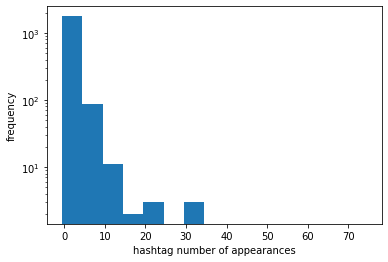

In [ ]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
counts.head()

0    2
1    1
2    1
3    1
4    2
Name: counts, dtype: int64

## Save ds

In [ ]:
# Save dfs
sent.to_csv("data/sent.csv")
# words_stp.to_csv("data/words_stp.csv")
# word_w.to_csv("data/word_w.csv")
# word_ste_w.to_csv("data/word_ste_w.csv")

## Describe

<BarContainer object of 2 artists>

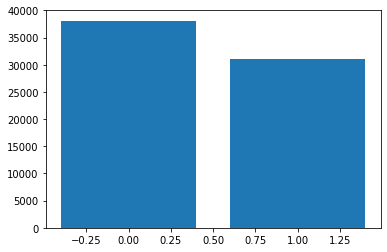

In [ ]:
# Target var
plt.bar(words_stp.tgt.value_counts().index,words_stp.tgt.value_counts())

[('like', 408), ('fire', 355), ('amp', 344), ('new', 339), ('get', 309), ('bomb', 230), ('via', 218), ('one', 204), ('peopl', 198), ('go', 187)]


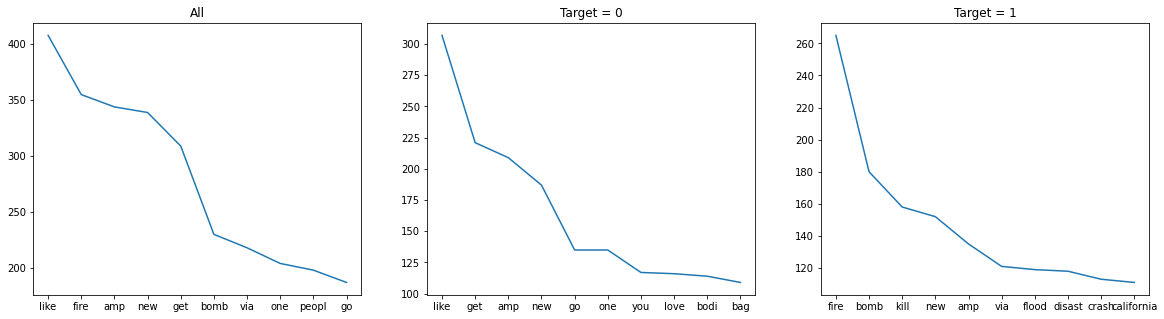

In [ ]:
# Words frequencies
#fdist = FreqDist(words.word)
#fdist = FreqDist(words_pnk.word)
#fdist = FreqDist(words_stp.word)
fdist = FreqDist(words_stp.word_ste)
fdist0 = FreqDist(words_stp[words_stp.tgt==0].word_ste)
fdist1 = FreqDist(words_stp[words_stp.tgt==1].word_ste)
print(fdist.most_common(10))

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(nrows=1, ncols=3)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot([fdist.most_common(10)[x][0] for x in range(10)],[fdist.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("All")

ax0 = fig.add_subplot(gs[0, 1])
ax0.plot([fdist0.most_common(10)[x][0] for x in range(10)],[fdist0.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("Target = 0")

ax0 = fig.add_subplot(gs[0, 2])
ax0.plot([fdist1.most_common(10)[x][0] for x in range(10)],[fdist1.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("Target = 1")

plt.show()

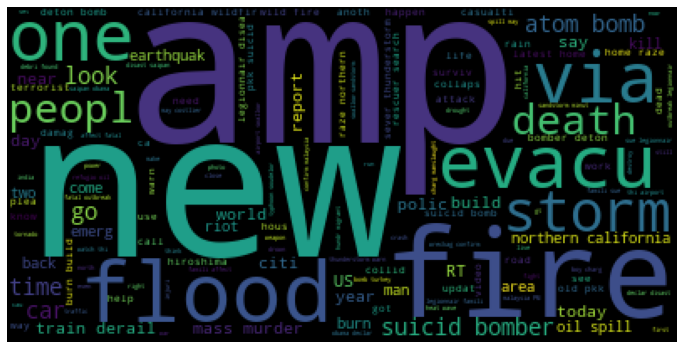

In [ ]:
# Cloud of words
wordcloud = WordCloud().generate(" ".join(words_stp[words_stp.tgt==1].word_ste))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Check https:
http = []
for i in range(len(data)):
  if 'http' in data.text[i]:
    http.append(data.text[i])
#http

In [ ]:
# Hashtag correlation
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

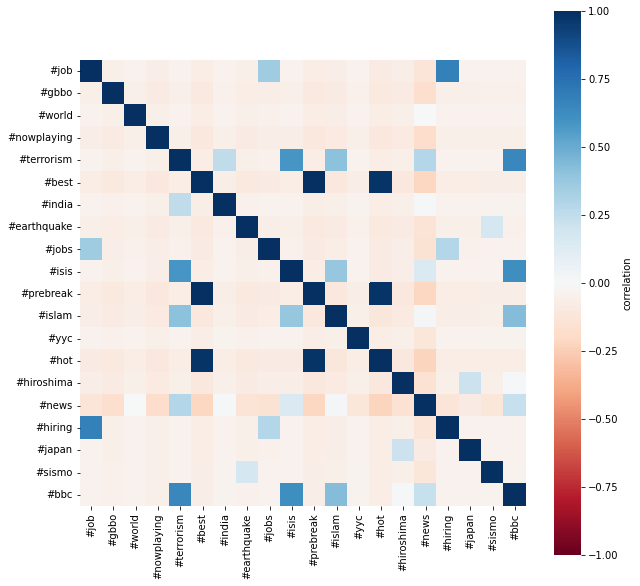

In [ ]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()